# Train DDQN for trailer reversing
Here we instantiate a simulation of the trailer system, and train a DDQN agent to control it.  

Imports

In [7]:
# Import dependencies
import torch
import numpy as np
from numpy import array
import gym
from collections import namedtuple
from dqn_model import DoubleQLearningModel, ExperienceReplay
from IPython.core.debugger import set_trace
import dqn_model
from bicycleEnv import *

#Local files. 
from Visualize_combination_code import *
from Simulate_combination_code import *
from utility_functions import *

#import DDQNhelpers
from DDQNhelpers import *
#dqn_model.test_calculate_q_targets(calculate_q_targets)

In [8]:
# CPU should be enough, but feel free to play around with this if you want to.
device = torch.device("cpu")

# Environment
Define an environment that we are to learn.

In [9]:
##System initial conditions. 


L = 2 #Length rear axis to front axis
Ts = 0.2 #Sample interval in seconds. 

#Position x, y, and heading
initState = (5,0, 0)

#Yes, the truck is a bicycle these days. 
truck = BicycleEnv(L,Ts, initState)

# Actions
The DDQN framework and all helper functions here assume a structure where actions are defined as integers 

$a_i \in \{0,1,\ldots , N_a-1  \}$

This seems to be for making array operations within the framework easier and more lightweight. This actions are then mapped to something useful the agent can do, in this case a tuple containing steering and velocity like 

$a_i \mapsto \langle v_i, \delta_i \rangle$

The map is contained within the environment. 



In [10]:
#Draw an element from the map of actions
result = truck.action_map[2]
lala = truck.action_map[2].vel
print("Vel:" ,result.vel,"Steering:", result.steeringRad)

Vel: 1 Steering: 0.7853981633974483


Instantiate a system model and run a simulation for a sanity check. 

In [11]:

truck_pos_x = []
truck_pos_y = []
truck_angle = []

action = 2

print("Simulation for velocity", truck.action_map[action].vel, "m/s and steering", np.rad2deg(truck.action_map[action].steeringRad)   )

for step_number in range(np.int(1e3)):
    
        #velocity = -0.1+np.sin(step_number/1e3*np.pi)
        #steering_percentage = np.sin(step_number/1e2*np.pi)
 
        
        state,_,_  = truck.step(action) 
        
        truck_pos_x.append(state[0])
        truck_pos_y.append(state[1])
        truck_angle.append(state[2])
        #truck_rot.append(truck_rotation)
        #trailer1_rot.append(first_trailer_rotation)
        #trailer2_rot.append(second_trailer_rotation)


#Reset before training on network.         
truck.reset()



Simulation for velocity 1 m/s and steering 45.0


array([5, 0, 0])

Animate data for a sanity check

<IPython.core.display.Javascript object>


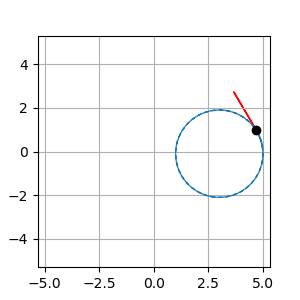

In [12]:
from animateRectangle import* 

%matplotlib notebook 

#The previous code was put in a separate class, try it here. 
#%matplotlib tk 
fig= plt.figure()
#ax.axis('equal')
fig.set_dpi(100)
fig.set_size_inches(3, 3)
B =0

rectAnim = animateRectangle(fig, B,L, truck_pos_x, truck_pos_y, truck_angle)

anim = rectAnim.animate(Ts*1000)
plt.show()
plt.grid()

In [13]:
def train_loop_ddqn( env, ddqn, replay_buffer, num_episodes, enable_visualization=False, batch_size=64, gamma=.94):        
    Transition = namedtuple("Transition", ["s", "a", "r", "next_s", "t"])
    #Things we log per each time step each episode. 
    perStepLogTuple = namedtuple("perStepLog", ["Px", "Py","angleRad", "action"])
    
    #Nesteld tuples 
    perEpisodeLogTuple = namedtuple("perEpLog", ["perStepLog", "eps", "R", "Ravg"])
    
    trainingLog = perEpisodeLogTuple(perStepLog = [], eps = [], R=[], Ravg=[] )
    
    #Initial and final probability of taking a random action
    eps = 0.99
    eps_end = 0.1 
    
    #Epsilon decays this much each apisode
    #eps_decay = .01
    eps_decay = 0.002
    tau = 1000
    cnt_updates = 0
    R_buffer = []
    R_avg = []
    
    print('Starting to train.')
    
    for i in range(num_episodes):
        state = env.reset() # Initial state
        state = state[None,:] # Add singleton dimension, to represent as batch of size 1.
        finish_episode = False # Initialize
        ep_reward = 0 # Initialize "Episodic reward", i.e. the total reward for episode, when disregarding discount factor.
        q_buffer = []
        steps = 0
        maxSteps = 100
        
        perStepLog = perStepLogTuple(Px =[], Py =[], action =[], angleRad = [])
        
        while not finish_episode and steps < maxSteps:
           
            if enable_visualization:
                env.render() # comment this line out if you don't want to / cannot render the environment on your system
            steps += 1

            # Take one step in environment. No need to compute gradients,
            # we will just store transition to replay buffer, and later sample a whole batch
            # from the replay buffer to actually take a gradient step.
            q_online_curr, curr_action = calc_q_and_take_action(ddqn, state, eps)
            q_buffer.append(q_online_curr)
            
            #Velocity is constant for now
            new_state, reward, finish_episode,  = env.step(curr_action) # take one step in the evironment
            
            perStepLog.Px.append(new_state[0] )
            perStepLog.Py.append(new_state[1] )
            perStepLog.angleRad.append(new_state[2] )
            perStepLog.action.append(curr_action)
            
            #set_trace()
            
            new_state = new_state[None,:]
            
            
            # Assess whether terminal state was reached.
            # The episode may end due to having reached 200 steps, but we should not regard this as reaching the terminal state, and hence not disregard Q(s',a) from the Q target.
            # https://arxiv.org/abs/1712.00378
            #nonterminal_to_buffer = not finish_episode or steps == maxSteps
            
            #For this agent the above shoudlnt hold
            nonterminal_to_buffer = not finish_episode 
            
            # Store experienced transition to replay buffer
            replay_buffer.add(Transition(s=state, a=curr_action, r=reward, next_s=new_state, t=nonterminal_to_buffer))

            state = new_state
            ep_reward += reward
            
            # If replay buffer contains more than 1000 samples, perform one training step
            if replay_buffer.buffer_length > 1000:
                
                loss = sample_batch_and_calculate_loss(ddqn, replay_buffer, batch_size, gamma)
                ddqn.optimizer.zero_grad()
                loss.backward()
                ddqn.optimizer.step()

                cnt_updates += 1
                if cnt_updates % tau == 0:
                    ddqn.update_target_network()
        #########################
        ## End of episode
        eps = max(eps - eps_decay, eps_end) # decrease epsilon        
        
        R_buffer.append(ep_reward)
         
        # Running average of episodic rewards (total reward, disregarding discount factor)
        R_avg.append(.05 * R_buffer[i] + .95 * R_avg[i-1])  if i > 0 else  R_avg.append(R_buffer[i])
        
        trainingLog.perStepLog.append(perStepLog)
        trainingLog.eps.append(eps)
        trainingLog.Ravg.append(R_avg[-1])
        trainingLog.R.append(ep_reward )

        if(i%10 == 0):
            print('Episode: {:d}, Total Reward (running avg): {:4.0f}, Epsilon: {:.3f}'.format( i, R_avg[-1], eps))
        #print('Episode: {:d}, Total Reward (running avg): {:4.0f} ({:.2f}) Epsilon: {:.3f}, Avg Q: {:.4g}'.format(i, ep_reward, R_avg[-1], eps, np.mean(np.array(q_buffer))))
        
        # If running average > 195 (close to 200), the task is considered solved
        if R_avg[-1] > 195:
            return trainingLog
        
    print("Training finished.")
    return trainingLog

Train.

In [ ]:
# Create the environment
#env = gym.make("CartPole-v0")

# Enable visualization? Does not work in all environments.
enable_visualization = False

#Actions are full turn left, straight, full turn right
#actions = (-1,0,1)


# Initializations


num_actions = len(truck.action_map.keys()) #TODO: Hardcoded now, do something more fancy later.
num_states = len(truck.initState)

#Training hyperparameters. 
num_episodes = 700
batch_size = 128
gamma = .94
learning_rate = 1e-3

# Object holding our online / offline Q-Networks
ddqn = DoubleQLearningModel(device, num_states, num_actions, learning_rate)

# Create replay buffer, where experience in form of tuples <s,a,r,s',t>, gathered from the environment is stored 
# for training
replay_buffer = ExperienceReplay(device, num_states)

# Train
#set_trace()
#R, R_avg = train_loop_ddqn(ddqn, env, replay_buffer, num_episodes, enable_visualization=enable_visualization, batch_size=batch_size, gamma=gamma)

#DDQNhelpers.
#DDQNhelpers.
#set_trace()
trainingLog = train_loop_ddqn( truck, ddqn, replay_buffer, num_episodes, enable_visualization, batch_size, gamma)

Starting to train.
Episode: 0, Total Reward (running avg): -12492, Epsilon: 0.988
Episode: 10, Total Reward (running avg): -10729, Epsilon: 0.968
Episode: 20, Total Reward (running avg): -10608, Epsilon: 0.948
Episode: 30, Total Reward (running avg): -10042, Epsilon: 0.928
Episode: 40, Total Reward (running avg): -9220, Epsilon: 0.908
Episode: 50, Total Reward (running avg): -9169, Epsilon: 0.888
Episode: 60, Total Reward (running avg): -8015, Epsilon: 0.868
Episode: 70, Total Reward (running avg): -7748, Epsilon: 0.848
Episode: 80, Total Reward (running avg): -7311, Epsilon: 0.828
Episode: 90, Total Reward (running avg): -6969, Epsilon: 0.808
Episode: 100, Total Reward (running avg): -6268, Epsilon: 0.788
Episode: 110, Total Reward (running avg): -6358, Epsilon: 0.768
Episode: 120, Total Reward (running avg): -6911, Epsilon: 0.748
Episode: 130, Total Reward (running avg): -6191, Epsilon: 0.728
Episode: 140, Total Reward (running avg): -6029, Epsilon: 0.708
Episode: 150, Total Reward (

In [ ]:
#Disable the liveplot here
%matplotlib inline

#print(type(episode))
#plt.plot( episode[pos_x], episode[pos_y] )

plt.figure() 

def printEpisode(episode, i, text = None ):
    #Plot startpoint
    plt.plot(episode.Px[0],episode.Py[0],  'bo' )

    #Plot whole trajectory. 
    if(text == None):
        plt.plot( episode.Px, episode.Py, label = "Episode " + str(i) )
    else:
        plt.plot( episode.Px, episode.Py,'k--', label = "Episode " + str(i) + text )
    #legend()
    plt.gca().legend()
    plt.plot(episode.Px[-1],episode.Py[-1],  'kx' )
    

for i, episode in enumerate(trainingLog.perStepLog):
    if (i%100==0):
        printEpisode(episode,i)
    

#Find the episode that gave us the highest value 

maxInd = np.argmax( trainingLog.R  )

episodeWithMostReward = trainingLog.perStepLog[maxInd]

printEpisode(episodeWithMostReward, maxInd, " Highest reward")
    
plt.figure() 

plt.plot(-np.log( np.abs(trainingLog.R)))
plt.title('Reward')

plt.figure() 

plt.plot(trainingLog.eps*100)
plt.title('Epsilon (probability to take a random action)')

#for episode in train_log: 
#plt.plot(episode.steering_angle)
    

Analyze the episode with most reward a bit further. 

In [ ]:
## Plot the actions taken for the best episode 

vel = []
steeringAngle = []
 
actionTuple = truck.action_map[0]
for a in episodeWithMostReward.action: 
    #Convert action integer number to the tuple of actions we defined. 
    actionTuple = truck.action_map[a]
    vel.append(actionTuple.vel)
    steeringAngle.append(actionTuple.steeringRad)

fig, ax = plt.subplots(1, 2)

ax[0].plot(vel, 'r', label = 'Velocity') #row=0, col=0
#ax[1, 0].plot(range(10), 'b') #row=1, col=0
ax[1].plot(np.rad2deg(steeringAngle), 'g') #row=0, col=1
#ax[1, 1].plot(range(10), 'k') #row=1, col=1

plt.show()
plt.figure()     
#plt.plot(vel)
#plt.title('Actions in the episode with most reward')

In [ ]:
from animateRectangle import* 

%matplotlib notebook 

#The previous code was put in a separate class, try it here. 
#%matplotlib tk 
fig= plt.figure()
#ax.axis('equal')
fig.set_dpi(100)
fig.set_size_inches(3, 3)
B =0

log = episodeWithMostReward


rectAnim = animateRectangle(fig, B,L, log.Px, log.Py, log.angleRad)

anim = rectAnim.animate(Ts*1000)
plt.show()
plt.grid()

In [ ]:
log = trainingLog.perStepLog[0].Px
print(log)